<a href="https://colab.research.google.com/github/LuZhang0128/Perspectives/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
!pip install -U git+http://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git --quiet
!pip install NRCLex --quiet
!pip install -U kaleido --quiet
!pip install transformers --quiet
!pip install imbalanced-learn --quiet
import imblearn
import pandas as pd
import re
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import wordcloud
import spacy
import gensim
import numpy as np 
import seaborn as sns
import sklearn.metrics.pairwise 
import sklearn.manifold 
import sklearn.decomposition 
import lucem_illud
import datetime as dt
import pandas as pd
import lucem_illud
import math
import sklearn.feature_extraction.text
import sklearn.feature_extraction
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt
import gensim
import wordcloud
from lucem_illud.processing import normalizeTokens, trainTestSplit, word_tokenize, sent_tokenize
from nrclex import NRCLex
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
# import plotly.express as px

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load and Clean Data
Here I've collaborated with my friend and have written a scraper for Twitter data. However, it only randomly send back a certain amount of Tweets per day every time I try to make request through the code. Here for this class project, I just used one output file, and can expand the scale by running the program multiple times. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read in data from several different requests
df1 = pd.read_csv('/content/drive/MyDrive/Perspectives/data/twitter_info_reply1.csv')
df = df1.drop_duplicates().reset_index(drop=True)

In [ ]:
# remove urls and uninformative information like websites and '@'s
cleaned_text = []
for row in df['m_content']:
    text = str(row)
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\B[@]\S+\b', '', text)
    cleaned_text.append(text)

df['text'] = cleaned_text
df['g_publish_time']= pd.to_datetime(df['g_publish_time'])
df = df.dropna(subset=['text'])

In [ ]:
print(len(df))
df.head()

123517


,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publish_time,r_like_num,r_trans_num,u_id,keyword,in_reply_to_screen_name,in_reply_to_status_id,u_nickname,u_area,screen_name,text
0,http://twitpic.com/gh4w - Wolf-dieter ring #blm,https://twitter.com/jbenno/status/962079197,962079197,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Wolf-dieter ring #blm
1,http://twitpic.com/gh3o - Hier @presseschauer ...,https://twitter.com/jbenno/status/962066767,962066767,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Hier und #blm
2,@furukama the leagel dabate on trust and commu...,https://twitter.com/jbenno/status/962226263,962226263,NaN,NaN,0,2008-10-16,0,0,10177792,BLM,furukama,962226263,Joerg Blumtritt,Abu Dhabi,jbenno,the leagel dabate on trust and communications...
3,http://twitpic.com/gno2 - Noshow-tisch #blm,https://twitter.com/jbenno/status/963782003,963782003,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Noshow-tisch #blm
4,http://twitpic.com/gno6 - Buffet #blm,https://twitter.com/jbenno/status/963782458,963782458,NaN,NaN,0,2008-10-17,0,0,10177792,BLM,NaN,None,Joerg Blumtritt,Abu Dhabi,jbenno,- Buffet #blm


In [ ]:
# split the data to before the event and after the event
# before is 0 and after is 1
before = []
for i in df.iloc:
  # print(i.g_publish_time)
  # print(i.g_publish_time < pd.to_datetime('2020-05-25'))
  if i.g_publish_time < pd.to_datetime('2020-05-25'):
    before.append(0)
  else:
    before.append(1)

df['target'] = before

In [ ]:
# create tokens for future use
df['tokenized_text'] = df['text'].apply(lambda x: word_tokenize(x))
df['normalized_text'] = df['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [ ]:
df['tokenized_sents'] = df['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [normalizeTokens(s) for s in x])

In [ ]:
# save the data
df.to_csv('/content/drive/MyDrive/Perspectives/df.csv')
df.to_pickle('/content/drive/MyDrive/Perspectives/df.pkl')

In [ ]:
# read in the data
df = pd.read_csv('/content/drive/MyDrive/BLM_data/df.csv')

# Basic Plots

In [ ]:
# number of posts per day
df_gb = df.groupby(['g_publish_time']).size()

plt.figure(figsize=(10,5))
plt.plot(df_gb, 'o',label="Number of Posts", markersize=1, linewidth=0.1)
plt.xticks(rotation=90)
plt.title("Number of Posts per day")
plt.legend()
plt.show()

## Word Cloud

In [ ]:
# overall word cloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets.pdf", format = 'pdf')

In [ ]:
# create seperate dataset for before and after the event
df_before = df[df["target"]==0]
df_after = df[df["target"]==1]

In [ ]:
# word cloud before the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_before['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets before 2020-05-25.pdf", format = 'pdf')

In [ ]:
# word cloud after the event
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=3000, height=2000, mode='RGBA', collocations=False, scale=.5).generate(' '.join(df_after['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("#BLM Tweets after 2020-05-25.pdf", format = 'pdf')

# Pre-trained BERT model for Emotion Classification

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='emotion'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
from scipy.special.orthogonal import jacobi
sent = df['text']

joy = []
optimism = []
anger = []
sadness = []

# j = 0

for sent_text in sent:
  # print(j)
  sent_text = preprocess(sent_text)
  encoded_input = tokenizer(sent_text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)  

  ranking = np.argsort(scores)
  ranking = ranking[::-1]
  for i in range(scores.shape[0]):
      l = labels[ranking[i]]
      s = scores[ranking[i]]

      if l=='joy':
        joy.append(s)
      elif l=='optimism':
        optimism.append(s)
      elif l=='anger':
        anger.append(s)
      elif l=='sadness':
        sadness.append(s)

  # j += 1

In [ ]:
df['joy'] = joy
df['optimism'] = optimism
df['anger'] = anger
df['sadness'] = sadness

In [ ]:
# save the data
# df.to_csv('/content/drive/MyDrive/Perspectives/df_emotion.csv')
# df.to_pickle('/content/drive/MyDrive/Perspectives/df_emotion.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Perspectives/df_emotion.pkl')

In [ ]:
mean_joy = df.groupby('g_publish_time')['joy'].mean().reset_index()
mean_optimism = df.groupby('g_publish_time')['optimism'].mean().reset_index()
mean_anger = df.groupby('g_publish_time')['anger'].mean().reset_index()
mean_sadness = df.groupby('g_publish_time')['sadness'].mean().reset_index()

In [ ]:
mean_joy.loc[mean_joy['g_publish_time'] == '2016-01-01']

In [ ]:
mean_joy.loc[mean_joy['g_publish_time'] == '2020-05-25']

In [ ]:
# plot average joy score with low alpha value
plt.scatter(mean_joy['g_publish_time'], mean_joy['joy'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_joy['g_publish_time'] = pd.to_datetime(mean_joy['g_publish_time'])
mean_joy['g_publish_time']=mean_joy['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_joy['g_publish_time'][2269:3875]
y1 = mean_joy['joy'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

from sklearn.metrics import r2_score
print(r2_score(y1, m1*x1+b1))

x2 = mean_joy['g_publish_time'][3875:]
y2 = mean_joy['joy'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

print(r2_score(y2, m2*x2+b2))

# plot
plt.xlabel("Date")
plt.ylabel("Average Joy Score")
plt.legend(loc = 'upper right')
plt.title('Average Joy Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Joy Score per Day')
plt.show()

print(m1,m2)

In [ ]:
# plot average optimism score with low alpha value
plt.scatter(mean_optimism['g_publish_time'], mean_optimism['optimism'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_optimism['g_publish_time'] = pd.to_datetime(mean_optimism['g_publish_time'])
mean_optimism['g_publish_time']=mean_optimism['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_optimism['g_publish_time'][2269:3875]
y1 = mean_optimism['optimism'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_optimism['g_publish_time'][3875:]
y2 = mean_optimism['optimism'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Optimism Score")
plt.legend(loc = 'upper right')
plt.title('Average Optimism Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Optimism Score per Day')
plt.show()

In [ ]:
# plot average anger score with low alpha value
plt.scatter(mean_anger['g_publish_time'], mean_anger['anger'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_anger['g_publish_time'] = pd.to_datetime(mean_anger['g_publish_time'])
mean_anger['g_publish_time']=mean_anger['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_anger['g_publish_time'][2269:3875]
y1 = mean_anger['anger'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_anger['g_publish_time'][3875:]
y2 = mean_anger['anger'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Anger Score")
plt.legend(loc = 'upper right')
plt.title('Average Anger Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Anger Score per Day')
plt.show()

In [ ]:
# plot average sadness score with low alpha value
plt.scatter(mean_sadness['g_publish_time'], mean_sadness['sadness'], c = 'grey', alpha = 0.05)

# convert date to numerical values
mean_sadness['g_publish_time'] = pd.to_datetime(mean_sadness['g_publish_time'])
mean_sadness['g_publish_time']=mean_sadness['g_publish_time'].map(dt.datetime.toordinal)

# linear regression before and after the event
x1 = mean_sadness['g_publish_time'][2269:3875]
y1 = mean_sadness['sadness'][2269:3875]
m1,b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1 + b1,'--', label='2016/01/01 - Event', linewidth=2, c = 'tab:blue')

x2 = mean_sadness['g_publish_time'][3875:]
y2 = mean_sadness['sadness'][3875:]
m2,b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2,'--', label='Event - 2022/02/15', linewidth=2, c = 'tab:orange')

# plot
plt.xlabel("Date")
plt.ylabel("Average Sadness Score")
plt.legend(loc = 'upper right')
plt.title('Average Sadness Score per Day',fontweight ='bold',size=14)
plt.savefig('Average Sadness Score per Day')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = x1
y = y1

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# Machine Learning Model


In [ ]:
# import the manual label of Twitter accounts
label = pd.read_csv('Perspectives_Labelling.csv').iloc[:, [0,8]]
label = label.loc[label["number"] != -1]

In [ ]:
label 

,account,number
0,jbenno,4
1,keith_bloke,4
2,society08085469,4
3,ResmaaMenakem,3
4,AmyJNobles,3
...,...,...
475,SWPDUB,4
476,DiametricSlant,4
477,FindingKJMovie,1
478,WArthurJ1,3


In [ ]:
# merge and select tweets with labeled accounts
labeled_df = df.merge(label, left_on='screen_name', right_on='account', how='inner')

In [ ]:
# use Tf-Idf to vectorize the tweet text
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(labeled_df['text'])

In [ ]:
# split training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(TFVects, labeled_df['number'], test_size=0.33, random_state=42)

In [ ]:
# use SMOTE method to oversample the minority classes, and balance the imbalanced dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
rf.score(X_train, y_train)

0.9825246710526315

In [ ]:
rf.score(X_test, y_test)

0.7026338147833475

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='none')
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(penalty='none')

In [ ]:
lr.score(X_train, y_train)

0.973889802631579

In [ ]:
lr.score(X_test, y_test)

0.7221750212404418

In [ ]:
# SVC
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [ ]:
svm.score(X_train, y_train)

0.9385279605263158

In [ ]:
svm.score(X_test, y_test)

0.7094307561597282

In [ ]:
# MultinomialNB
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
mnb.score(X_train, y_train)

0.9276315789473685

In [ ]:
mnb.score(X_test, y_test)

0.6771452846219201

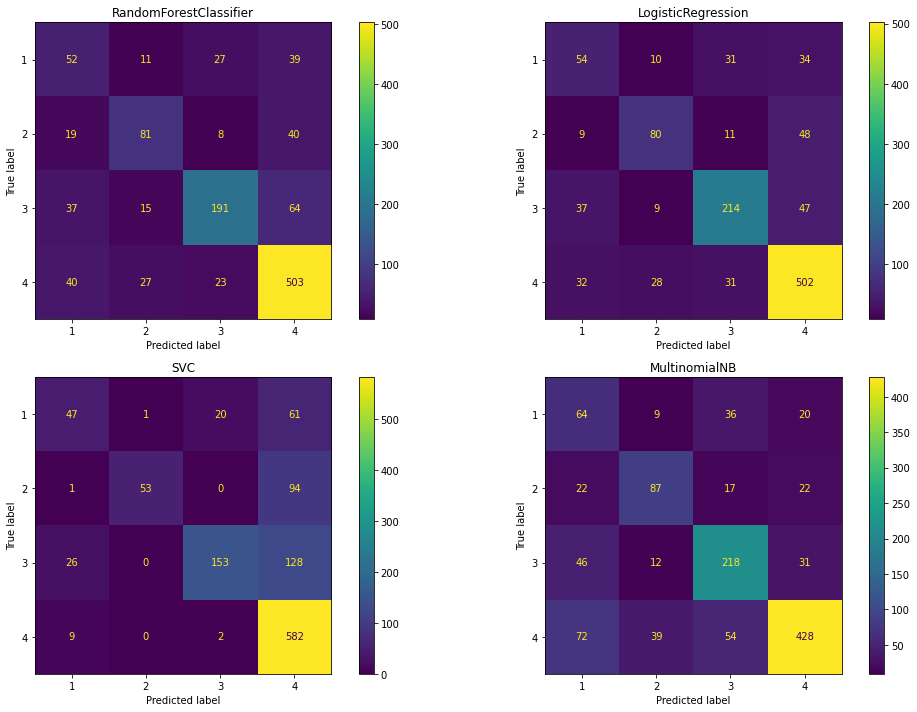

In [ ]:
# plot the confusion matricies
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

classifiers = [rf, lr, svm, mnb]

count = 0
for cls, ax in zip(classifiers, axes.flatten()):
    if count == len(classifiers):
        break

    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax)
    ax.title.set_text(type(cls).__name__)
    count += 1
plt.tight_layout()  
plt.show()

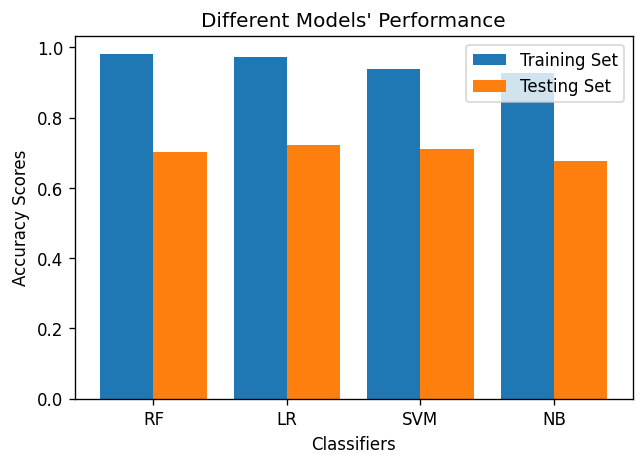

In [ ]:
# plot the accuracy scores for the training and testing sets
import matplotlib.pyplot as plt

scores_train = [0.9825246710526315, 0.973889802631579, 0.9385279605263158, 0.9276315789473685]
scores_test = [0.7026338147833475, 0.7221750212404418, 0.7094307561597282, 0.6771452846219201]
X = ['RF', 'LR', 'SVM', 'NB']

X_axis = np.arange(len(X))

plt.figure(dpi = 120)
plt.bar(X_axis - 0.2, scores_train, 0.4, label="Training Set")
plt.bar(X_axis + 0.2, scores_test, 0.4, label="Testing Set")
plt.xticks(X_axis, X)
plt.title("Different Models' Performance")
plt.xlabel('Classifiers')
plt.ylabel('Accuracy Scores')
plt.legend()
plt.savefig('accuracy')